In [6]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer

import numpy as np
from timeit import default_timer as timer

class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        self.mc_price = -1

    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def BSM_Greeks(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        time_bs_start = timer()
        bs_price = european_option.NPV()
        delta = european_option.delta()
        gamma = european_option.gamma() #second order
        vega = european_option.vega()
        rho = european_option.rho()
        theta = european_option.theta()
        time_bs_end = timer()
        time_bs = time_bs_end - time_bs_start
        print("Delta is ", delta)#Change in underlying price
        print("Gamma is ", gamma)#second order: rate of change in price
        print("Tho is ", rho)#Change in interest rate
        print("Vega is ", vega)#Change in volatility
        print("Theta is ", theta)#Change in time to expiration
        print("Time used for BS calculation in total is ", time_bs, ' seconds')
        
    '''
    MC by hand.
    https://qsctech-sange.github.io/Options-Calculator.html#%E5%AE%8C%E6%95%B4%E4%BB%A3%E7%A0%81
    
    '''
    def MC_price(self):
        iteration = 100000
        kind = 1 #call = 1, put = -1
        maturity_in_year = (self.maturity - self.calculation_date)/365
        zt = np.random.normal(0, 1, iteration)

        st = self.stock_price * np.exp((self.risk_free_rate - self.dividend_rate - .5 * self.volatility ** 2) * maturity_in_year + self.volatility * maturity_in_year ** .5 * zt)
        st = np.maximum(kind * (st - self.strike_price), 0)
        self.mc_price = np.average(st) * np.exp(-self.risk_free_rate * maturity_in_year)
        return self.mc_price
    
    '''
    https://chixiaoxue.github.io/2018/08/15/Python%E5%AE%9E%E7%8E%B0%E8%92%99%E7%89%B9%E5%8D%A1%E6%B4%9B%E6%A8%A1%E6%8B%9F%E7%9A%84%E6%9C%9F%E6%9D%83%E4%BC%B0%E5%80%BC/
    '''
    def MC_A_price(self):
        iteration = 1000000
        kind = 1 #call = 1, put = -1
        maturity_in_year = (self.maturity - self.calculation_date)/365
        #zt = np.random.normal(0, 1, iteration)
        np.random.seed(1000)
        ran = np.random.standard_normal((1,1, round(iteration/2)))
        ran = np.concatenate((ran,-ran),axis=2)
        ran = ran-np.mean(ran)
        ran = ran/np.std(ran)
        
        st = self.stock_price * np.exp((self.risk_free_rate - self.dividend_rate - .5 * self.volatility ** 2) * maturity_in_year + self.volatility * maturity_in_year ** .5 * ran)
        st = np.maximum(kind * (st - self.strike_price), 0)
        self.mc_price = np.average(st) * np.exp(-self.risk_free_rate * maturity_in_year)
        return self.mc_price
    
    def MC_A_Greeks(self):
        if self.mc_price == -1:
            self.MC_A_price()
            
        p_original = self.mc_price
        time_bs_start = timer()
        
        original_stock = self.stock_price
        change_stock_price = 0.1
        self.stock_price = original_stock + change_stock_price
        p_plus = self.MC_A_price()
        self.stock_price = original_stock - change_stock_price
        p_minus = self.MC_A_price()
        self.stock_price = original_stock
        mc_delta = (p_plus - p_minus) / (2*change_stock_price)
        mc_gamma = (p_plus - 2*p_original + p_minus) /(change_stock_price*change_stock_price)
        print("delta in MC is: ", mc_delta)
        print("gamma in MC is: ", mc_gamma)
        
        change_r = 0.001
        original_r = self.risk_free_rate
        self.risk_free_rate = original_r + change_r
        p_plus = self.MC_A_price()
        self.risk_free_rate = original_r
        mc_rho = (p_plus - p_original) / change_r
        print("rho in MC is: ", mc_rho)
        
        change_sigma = 0.001
        original_sigma = self.volatility
        self.volatility = original_sigma + change_sigma
        p_plus = self.MC_A_price()
        self.volatility = original_sigma
        mc_vega = (p_plus - p_original) / change_sigma
        print("vega in MC is: ", mc_vega)
        
        self.calculation_date += 1
        p_plus = self.MC_A_price()
        change_in_time = 1.0 / 365
        mc_theta = (p_plus - p_original) / change_in_time
        print("theta in MC is: ", mc_theta)
        
        self.mc_price = p_original
        
        time_bs_end = timer()
        time_bs = time_bs_end - time_bs_start
        print("Time used for MC calculation in total is ", time_bs, ' seconds')
            
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


In [7]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option)
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe

def random_options_uniform(numbers = 0, index = 100):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    numbers = 10 
    maturity = np.linspace(xldate1, xldate2+1, 10)
    stock_price = np.linspace(100, 500, 10)
    strike_price = np.linspace(7, 650, 10)
    volatility = np.linspace(0.05, 0.90, 10)
    dividend_rate = np.linspace(0, 0.003, 10)
    risk_free_rate = np.linspace(0.001, 0.003, 10)
    option_type = ql.Option.Call
    
    counter = 0
    for i in range(numbers):
        for j in range(numbers):
            for k in range(numbers):
                for l in range(numbers):
                    for m in range(numbers):
                        for n in range(numbers):
                            counter += 1
                            if counter == index:
                                option = Option(calculation_date, ql.Date(int(maturity[i])), stock_price[j], strike_price[k], volatility[l], dividend_rate[m], risk_free_rate[n], option_type)
                                options.append(option)
    
    return options

def random_options_pd_uniform(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    numbers = 10 
    maturity = np.linspace(xldate1, xldate2+1, 10)
    stock_price = np.linspace(100, 500, 10)
    strike_price = np.linspace(7, 650, 10)
    volatility = np.linspace(0.05, 0.90, 10)
    dividend_rate = np.linspace(0, 0.003, 10)
    risk_free_rate = np.linspace(0.001, 0.003, 10)
    option_type = ql.Option.Call
    
    for i in range(numbers):
        for j in range(numbers):
            for k in range(numbers):
                for l in range(numbers):
                    for m in range(numbers):
                        for n in range(numbers):
                            option = Option(calculation_date, ql.Date(int(maturity[i])), stock_price[j], strike_price[k], volatility[l], dividend_rate[m], risk_free_rate[n], option_type)
                            options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe


In [8]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = abs(y - y_hat)
    stats['diff'].sort()
    print(stats['diff'])

    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats

def CheckAccuracy_RealPrice(x,y,y_hat):
    stats = dict()
    
    strike = x['strike_price'].values
    y = y * strike
    y_hat = y_hat * strike
    stats['diff'] = abs(y - y_hat)
    stats['diff'].sort()
    print(stats['diff'])


    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats
    
def CheckAccuracy_scaled(scale,y,y_hat):
    stats = dict()
    
    y = (y - scale.min_[6])/scale.scale_[6] 
    y_hat = (y_hat - scale.min_[6])/scaler.scale_[6] 
    stats['diff'] = abs(y - y_hat)
    stats['diff'].sort()
    print(stats['diff'])
    
    stats['diff_percentage'] = 100 * stats['diff'] / y
    np.where(stats['diff_percentage'] > 1)
    print(stats['diff_percentage'])

    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    

In [9]:
def DL_prediction(model, df):
    df['stock_price'] = df['stock_price']/df['strike_price']
    df['call_price'] = df['call_price']/df['strike_price']
    greek_input = df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    nn_original_price = model.predict(greek_input)[0][0] 
    return nn_original_price

def DL_prediction_scaled(scaler, model, df):
    scaled_training = scaler.transform(df)
    input_df = pd.DataFrame(scaled_training,columns=df.columns.values)
    greek_input = input_df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    nn_original_price = model.predict(greek_input)[0][0] 
    return nn_original_price

def DL_Greeks(model, df):
    
    time_mc_start = timer()
    
#The Greeks for DL model
#why it's forever negative, problem is my saving variables for Python!!

    change_stock_price = 0.1
    original_price = DL_prediction(model, df)
    bs_price = df['call_price'].values * df['strike_price'].values
    #print('percentage error: ', (abs(bs_price - (original_price * df['strike_price'].values)))/bs_price, '%')
    
    df['stock_price'] = (df['stock_price']*df['strike_price'] + change_stock_price)/df['strike_price']
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_plus = model.predict(greek_input)[0][0] 

    df['stock_price'] = (df['stock_price']*df['strike_price'] - 2*change_stock_price)/df['strike_price']
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_minus = model.predict(greek_input)[0][0] 
    df['stock_price'] = (df['stock_price']*df['strike_price'] + change_stock_price)/df['strike_price']

    dl_delta = (p_plus - p_minus) / (2*change_stock_price)
    dl_gamma = (p_plus - 2*original_price + p_minus) /(change_stock_price*change_stock_price)

    print("delta in MC is: ", dl_delta)
    print("gamma in MC is: ", dl_gamma)

    change_r = 0.001
    df['risk_free_rate'] = df['risk_free_rate'] + change_r
    greek_input = df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_plus = model.predict(greek_input)[0][0] 
    df['risk_free_rate'] = df['risk_free_rate'] - change_r
    dl_rho = (p_plus - original_price) / change_r
    print("rho in MC is: ", dl_rho)

    change_sigma = 0.001
    df['volatility'] = df['volatility'] + change_sigma
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_plus = model.predict(greek_input)[0][0] 
    df['volatility'] = df['volatility'] - change_sigma
    dl_vega = (p_plus - original_price) / change_sigma
    print("vega in MC is: ", dl_vega)

    change_in_time = 1.0 / 365
    df['maturity'] = df['maturity'] + change_in_time
    greek_input = df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_later = model.predict(greek_input)[0][0] 
    dl_theta = (p_later - original_price) / change_in_time
    print("theta in MC is: ", dl_theta)

    time_mc_end = timer()
    time_mc = time_mc_end - time_mc_start

    print("Time used for MC calculation in total is ", time_mc, ' seconds')


In [10]:
n = 1000000
random_df = random_options_pd(n)
uniform_df = random_options_pd_uniform()

In [24]:
from sklearn.preprocessing import MinMaxScaler

n = 1000000
df = random_df

n_train =  (int)(0.8 * n)
train = df[0:n_train]
test = df[n_train+1:n]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train)
scaled_testing = scaler.transform(test)
scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)

print("mutiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6],scaler.min_[6]))
X_train = scaled_training_df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = scaled_training_df['call_price'].values
X_test = scaled_testing_df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = scaled_testing_df['call_price'].values

mutiplying by 0.0020303997 and adding 0.000000


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=6,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1)
]

model.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=callbacks,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Train on 640000 samples, validate on 160000 samples
Epoch 1/30
 - 33s - loss: 1.1578e-04 - val_loss: 1.5794e-05
Epoch 2/30
 - 33s - loss: 9.1997e-06 - val_loss: 4.1893e-06
Epoch 3/30
 - 31s - loss: 5.7013e-06 - val_loss: 1.8515e-06
Epoch 4/30
 - 32s - loss: 4.4311e-06 - val_loss: 1.6472e-05
Epoch 00004: early stopping
The mean squared error (MSE) for the test data set is: 1.6508265461379002e-05


In [34]:
model_json = model.to_json()
with open("model_random.json", "w") as json_file:
    json_file.write(model_json)
        # serialize weights to HDF5
model.save_weights('model_weights_random.h5')
print("Saved model weights to disk")

Saved model weights to disk


In [39]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_random.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights_random.h5")
print("Loaded model from disk")
loaded_model.summary()

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
model = loaded_model

Loaded model from disk
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                350       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


[5.58471984e-09 4.55047585e-08 5.54719009e-08 ... 3.34500364e-02
 3.98730612e-02 5.13056132e-02]
Mean Squared Error:       1.652631738907336e-05
Root Mean Squared Error:  0.004065257358282912
Mean Absolute Error:      0.003215922130139655
Mean Percent Error:       0.01948087833924618


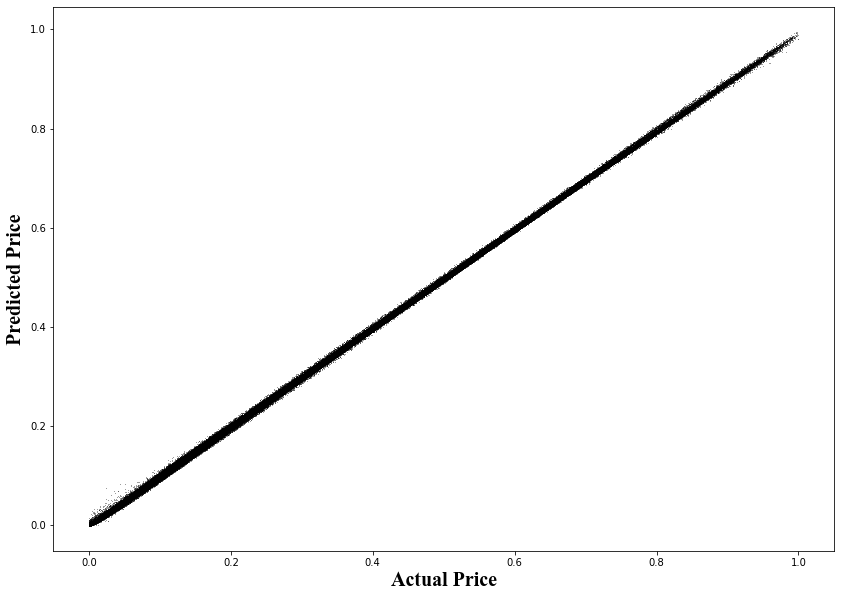

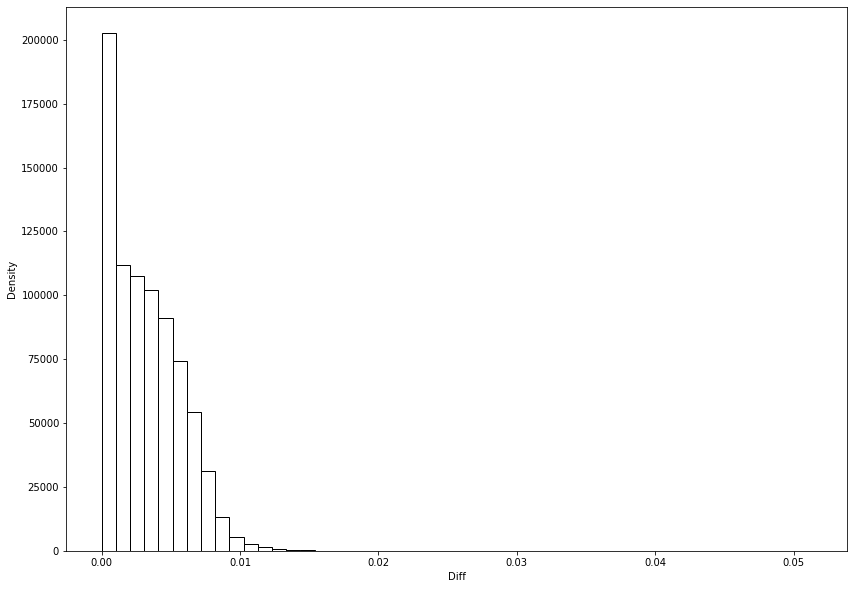

----------------------------------------------------------------------------------------------------
[6.57794217e-08 1.09732115e-07 2.26935551e-07 ... 2.84345232e-02
 2.95079838e-02 3.04766799e-02]
Mean Squared Error:       1.6508265779920457e-05
Root Mean Squared Error:  0.004063036522100245
Mean Absolute Error:      0.0032162025180003666
Mean Percent Error:       0.019421466808498728


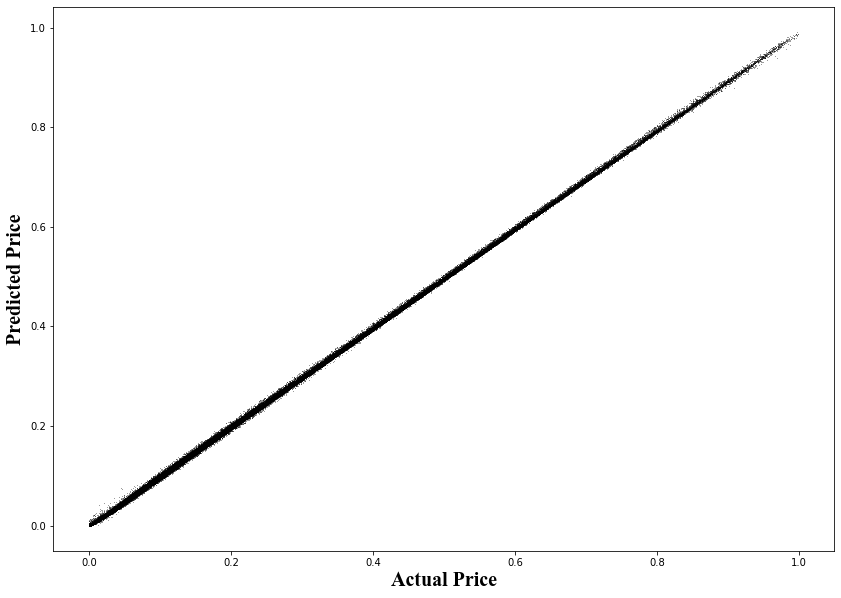

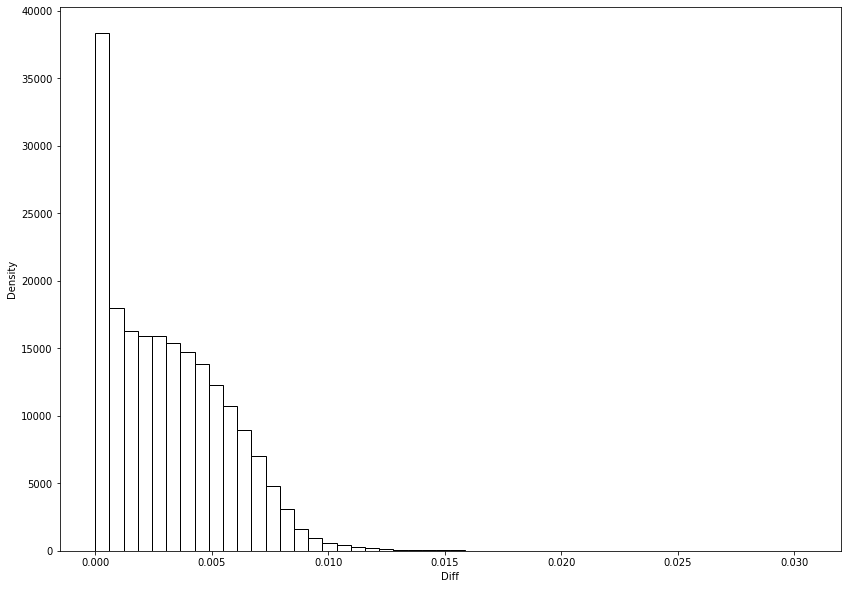

----------------------------------------------------------------------------------------------------
[3.26751418e-05 6.16890970e-05 1.12075114e-04 ... 1.40044222e+01
 1.45331188e+01 1.50101838e+01]
[3.55602313e-05 1.89173664e-05 2.02884840e-04 ... 1.87999201e+01
 9.03810869e+02 1.09817889e+02]


/Users/sica/Desktop/FinalYearProject/NNforOptionsPricing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error:       4.004432884768518
Root Mean Squared Error:  2.0011079143235926
Mean Absolute Error:      1.5840290286408394
Mean Percent Error:       0.019421526449503186


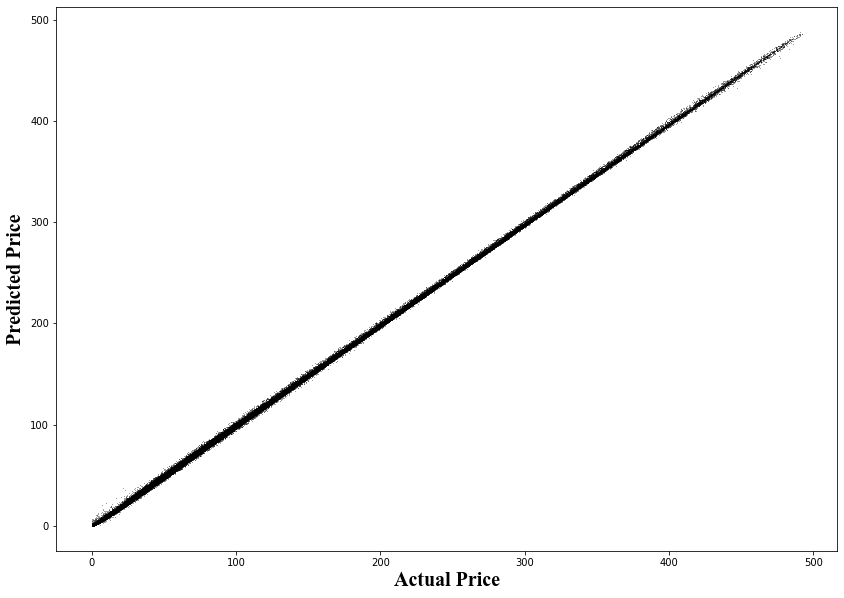

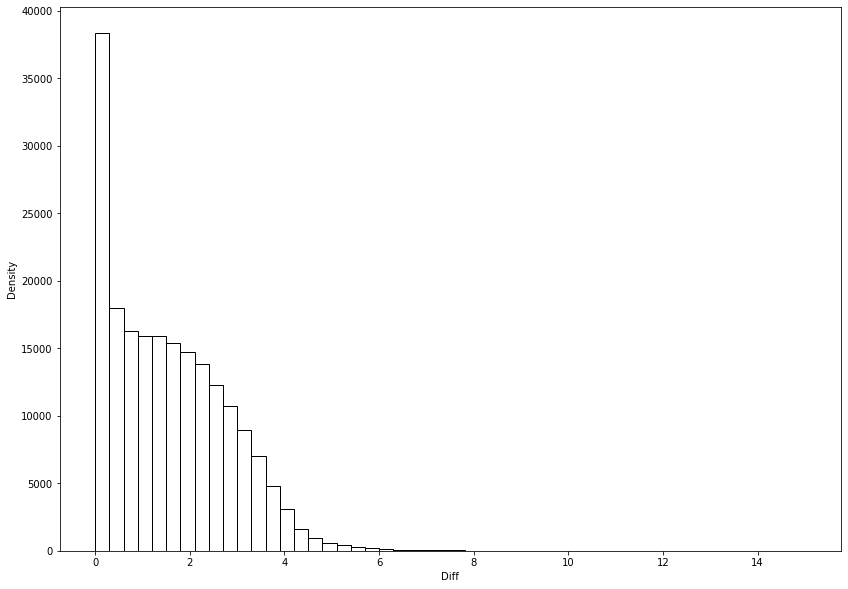

In [40]:
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
y_train_hat = model.predict(X_train)
y_train_hat = np.squeeze(y_train_hat)

CheckAccuracy(y_train, y_train_hat)
print('-'*100)
CheckAccuracy(y_test, y_test_hat)
print('-'*100)
CheckAccuracy_scaled(scaler, y_test, y_test_hat)


In [41]:
option = random_options(1)
#option = random_options_uniform(0, 2000)
dataframe = pd.DataFrame([option[0].data_set()])
dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']

print('Option Price with BSM: ',option[0].BSM_price())
print('Option Price with MC and normal random number: ',option[0].MC_price())
print('Option Price with MC and antithetic variates and moment matching: ',option[0].MC_A_price())
#print('Option Price with DL: ',DL_prediction(model, dataframe) * dataframe['strike_price'].values )
print('Option Price with DL: ',(DL_prediction_scaled(scaler, model, dataframe) - scaler.min_[6])/scaler.scale_[6]  )

print('-' * 80)
option[0].BSM_Greeks()
print('-' * 80)
option[0].MC_A_Greeks()
print('-' * 80)
DL_Greeks(model, dataframe)

Option Price with BSM:  199.1766682132856
Option Price with MC and normal random number:  199.97702802797545
Option Price with MC and antithetic variates and moment matching:  199.29213502039025
Option Price with DL:  199.85481881241924
--------------------------------------------------------------------------------
Delta is  0.8607727180748349
Gamma is  0.0005794292740622736
Tho is  185.01979121888814
Vega is  105.19162990465436
Theta is  -19.860908707657977
Time used for BS calculation in total is  2.610200044728117e-05  seconds
--------------------------------------------------------------------------------
delta in MC is:  0.8611399326046865
gamma in MC is:  0.0006200354363272708
rho in MC is:  184.98349885007315
vega in MC is:  105.82327107098877
theta in MC is:  -19.9889885424534
Time used for MC calculation in total is  0.29556147099992813  seconds
--------------------------------------------------------------------------------
delta in MC is:  -1.1920928955078125e-05
gamma in M

In [42]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_uniform.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights_uniform.h5")
print("Loaded model from disk")
loaded_model.summary()

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
model = loaded_model

Loaded model from disk
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                350       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


[7.61845456e-07 2.80613217e-06 4.76653394e-06 ... 8.76587708e-02
 8.96790506e-02 9.00086298e-02]
Mean Squared Error:       0.0003829640513091334
Root Mean Squared Error:  0.019569467323080958
Mean Absolute Error:      0.014990744196854389
Mean Percent Error:       0.09377768207172456


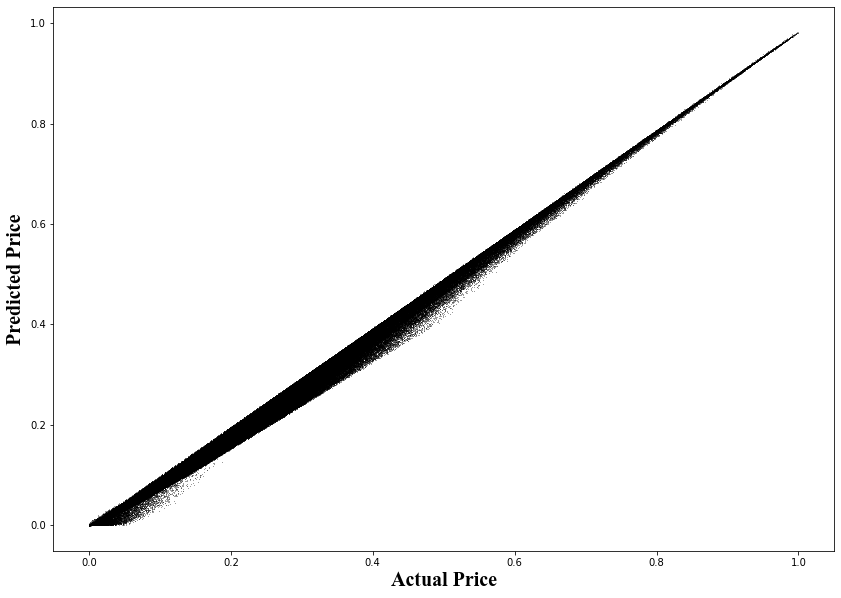

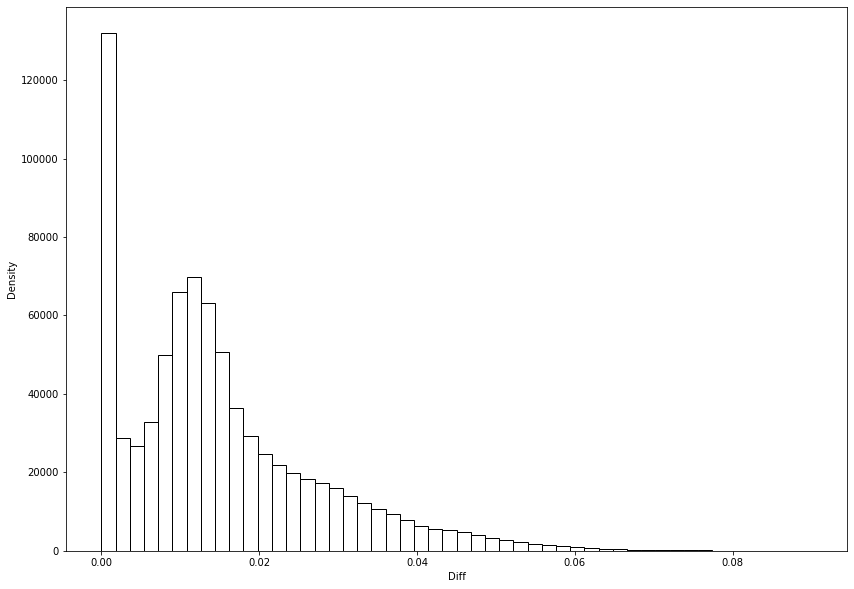

----------------------------------------------------------------------------------------------------
[7.92152548e-07 5.37234542e-06 6.97451525e-06 ... 8.47529015e-02
 8.49506711e-02 9.21783767e-02]
Mean Squared Error:       0.00038574880228278626
Root Mean Squared Error:  0.019640488850402534
Mean Absolute Error:      0.015034877306143586
Mean Percent Error:       0.09388227258996097


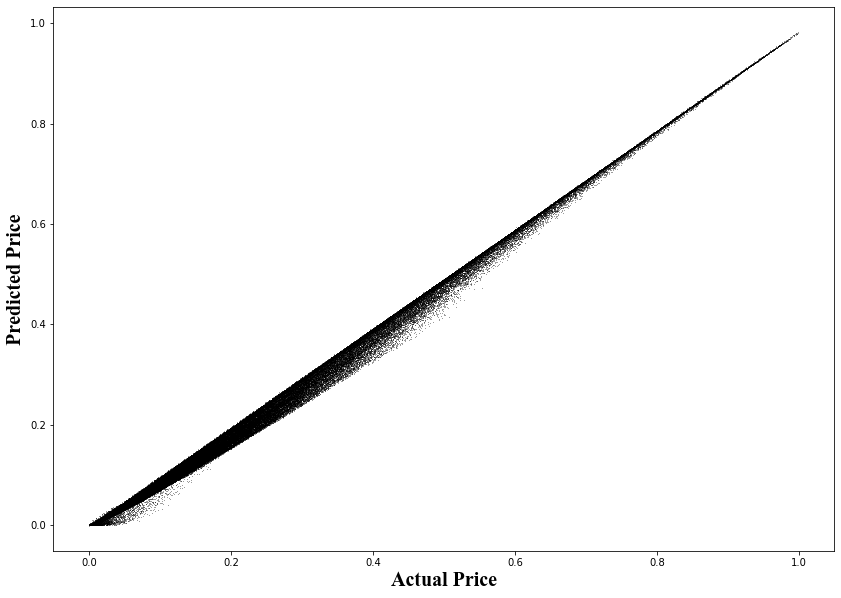

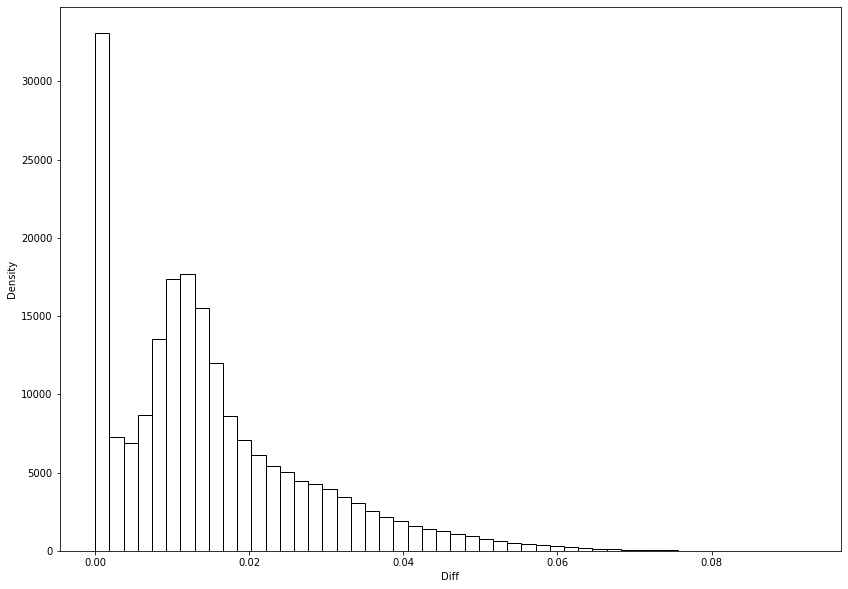

----------------------------------------------------------------------------------------------------
[3.90120846e-04 2.64594699e-03 3.43504121e-03 ... 4.17419869e+01
 4.18393878e+01 4.53991430e+01]
[4.24567018e-04 8.11397008e-04 6.21830985e-03 ... 5.60355869e+01
 2.60198061e+03 3.32150365e+02]


/Users/sica/Desktop/FinalYearProject/NNforOptionsPricing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error:       93.57115006473872
Root Mean Squared Error:  9.673218185523302
Mean Absolute Error:      7.404890798599718
Mean Percent Error:       0.09388232463488044


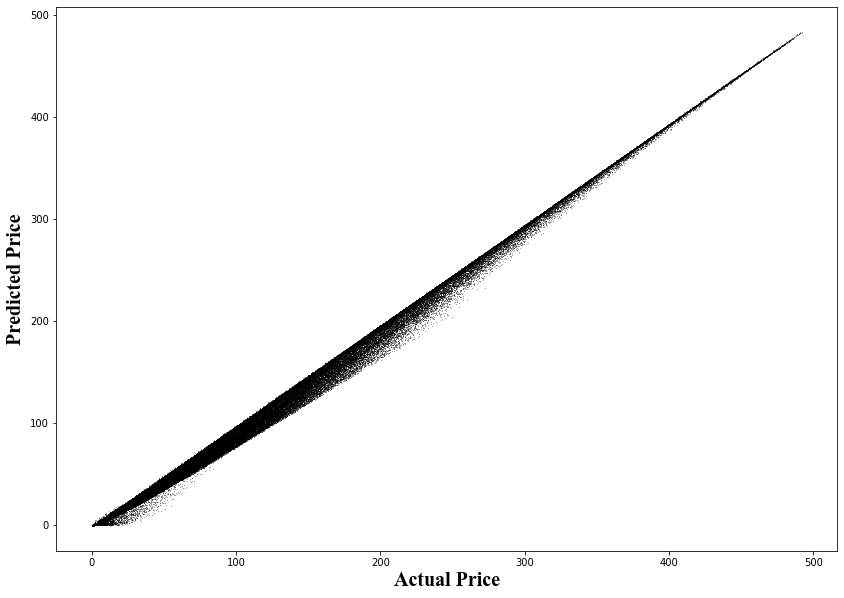

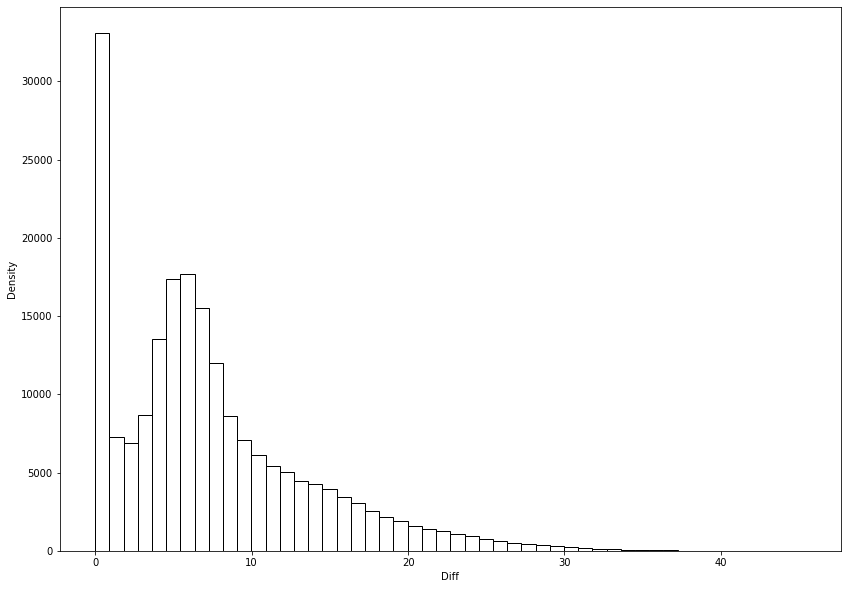

In [43]:
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
y_train_hat = model.predict(X_train)
y_train_hat = np.squeeze(y_train_hat)

CheckAccuracy(y_train, y_train_hat)
print('-'*100)
CheckAccuracy(y_test, y_test_hat)
print('-'*100)
CheckAccuracy_scaled(scaler, y_test, y_test_hat)


In [45]:
option = random_options(1)
#option = random_options_uniform(0, 2000)
dataframe = pd.DataFrame([option[0].data_set()])
dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']

print('Option Price with BSM: ',option[0].BSM_price())
print('Option Price with MC and normal random number: ',option[0].MC_price())
print('Option Price with MC and antithetic variates and moment matching: ',option[0].MC_A_price())
#print('Option Price with DL: ',DL_prediction(model, dataframe) * dataframe['strike_price'].values )
print('Option Price with DL: ',(DL_prediction_scaled(scaler, model, dataframe) - scaler.min_[6])/scaler.scale_[6]  )

print('-' * 80)
option[0].BSM_Greeks()
print('-' * 80)
option[0].MC_A_Greeks()
print('-' * 80)
DL_Greeks(model, dataframe)

Option Price with BSM:  346.1223851046279
Option Price with MC and normal random number:  346.3735524293227
Option Price with MC and antithetic variates and moment matching:  346.12771954845516
Option Price with DL:  339.9216857962875
--------------------------------------------------------------------------------
Delta is  0.9998760184947332
Gamma is  6.56848376490354e-07
Tho is  62.98160335230617
Vega is  0.05263904519036011
Theta is  -0.14188799269450902
Time used for BS calculation in total is  2.5349000679852907e-05  seconds
--------------------------------------------------------------------------------
delta in MC is:  0.9998883875664433
gamma in MC is:  1.613545919099124e-06
rho in MC is:  62.951782714719684
vega in MC is:  0.09724772712615959
theta in MC is:  -0.1532459620921145
Time used for MC calculation in total is  0.4183641399995395  seconds
--------------------------------------------------------------------------------
delta in MC is:  6.0498714447021484e-05
gamma in M